In [ ]:
import pickle
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from sympy import symbols, Eq, solve
from sympy import log as sym_log 
from subprocess import run

plt.style.use('style.yml')              # comment this line if you don't have a Latex installation
sys.path.append('../')
import python_utils as utils


n_fbg = 21

Importing data

In [24]:
with open('indentation_example/data.pkl', 'rb') as f:
    data = pickle.load(f)

X_ind = data['X_ind']
Y_ind = data['Y_ind']
Z_ind = data['Z_ind']


FBG_signal = data['FBG_signal']
force_signal = data['force_signal']

print('Number of samples:', len(X_ind))

Number of samples: 9


Visualization of the FBG signals

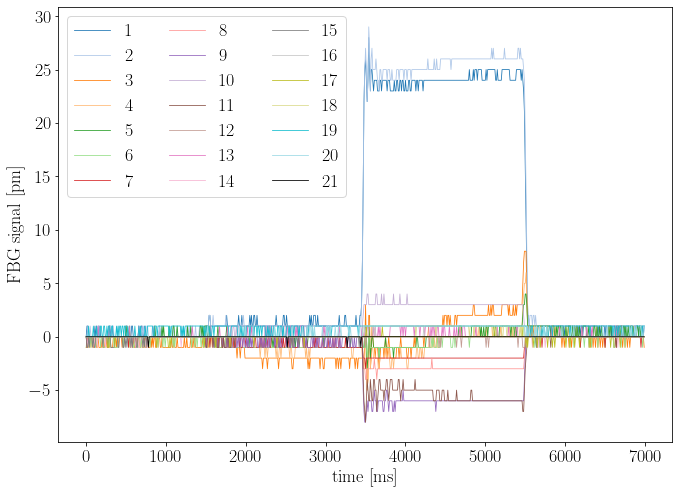

In [90]:
to_plot_ind = 5

ind_dur_cs = len(FBG_signal[1][to_plot_ind])        # duration of the signal in cs
ind_dur_ms = 10*ind_dur_cs                          # duration of the signal in ms

fig = plt.figure(figsize=(11, 8))
for i_k, k in enumerate(FBG_signal.keys()):
    color = colormaps['tab20'](i_k) if i_k < 20 else 'black'
    plt.plot(np.arange(len(FBG_signal[k][to_plot_ind]))*10,1000*FBG_signal[k][to_plot_ind], label = k, color=color)

plt.ylabel('FBG signal [pm]')
plt.xlabel('time [ms]')
plt.legend(ncol=3)
plt.show()


Separation of the positive and negative components of the FBG signal and application of the non linear transformation

In [71]:
def log_transf(x, offset, p_in, p_out, lin_factor, b_var=-1):
    # (p_in, p_out):        p_out is the desidered output when x=p_in is passed
    # offset:               log_transf(x=0)
    # lin_factor:           if low the transformation is almost linear, if high is highly non-linear
    if lin_factor == 0.:
        return (offset + (p_out-offset)/p_in * x, 0)
    elif b_var<0:
        var_b = symbols('var_b')
        eq = Eq((lin_factor+1)*sym_log(1.+var_b*p_in) - var_b*p_in,0)
        sols = solve( eq )
        print(sols)
        assert (0. in sols and len(sols)==2)
        b_var = float(f'{np.sort( np.array(sols) )[1]}')

    p_out = p_out - offset
    a = p_out/np.log(1+b_var*p_in)
    return (offset + a * np.log(1+b_var*x), b_var)

input_currs = np.zeros((2*n_fbg, ind_dur_cs))
p_in_pos = 0.384        # 99% quantile of positive signals  [see Table S1 in the Supplementary Material]
p_in_neg = 0.146        # 99% quantile of negative signals  [see Table S1 in the Supplementary Material]
offset   = 15
p_out = 50              # [pA] desidered output current when p_in_pos/neg are passed  [Note that when I_in=50 pA, the output spiking frequency is sim 50 Hz; see Fig. S1 in the Supplementary Material]
lin_factor = 11

b_val_pos = log_transf(0, offset, p_in_pos, p_out, lin_factor)[1]
b_val_neg = log_transf(0, offset, p_in_neg, p_out, lin_factor)[1]

for i in range(n_fbg):
    signal = FBG_signal[i+1][to_plot_ind]
    signal_pos = np.where(signal>=0, signal, 0)
    signal_neg = np.where(signal<0, -signal, 0)
    input_currs[i]       = log_transf(signal_pos, offset, p_in_pos, p_out, lin_factor, b_val_pos)[0]
    input_currs[i+n_fbg] = log_transf(signal_neg, offset, p_in_neg, p_out, lin_factor, b_val_neg)[0]


[0.0, 120.496572139030]
[0.0, 316.922491105394]


Definition of some utility function to setup weights and baseline currents

In [91]:
def str_line(ind, v, reps):
    str_i = str(ind)
    str_v = "\t".join([ f'{j:.2f}' for j in v for i in range(reps) ])
    return "\t".join([ str_i, str_v ])

def setup_L1_currents(path_curr_files, path_biases, input_curr):
    offsets = np.loadtxt(path_biases)
    with open(path_curr_files, 'w') as f:
        for i_n in range(input_curr.shape[0]):
            inp = input_curr[i_n] + offsets[i_n]
            f.write( str_line(i_n, inp, 1)+'\n' )

tau_results = 100
def temp_update(t, dur, start):
    to_ret = np.linspace(0,dur-start-1, dur-start)
    to_ret = np.exp( -(to_ret-t)/tau_results )
    to_ret[:int(t)] = 0
    return 1/tau_results*np.array(to_ret)


In [85]:
NETWORK_MODEL = 'SF-DIR'     # 'SC-BIO-EE' or 'SF-DIR'

config_dir      = f'indentation_example/{NETWORK_MODEL}/config_files'
weight_bias_dir = f'indentation_example/{NETWORK_MODEL}/weights_currs'
L1_curr_dir     = f'indentation_example/{NETWORK_MODEL}/specific_Ies'
sim_dir         = f'indentation_example/{NETWORK_MODEL}/sim'

if not os.path.isdir(sim_dir):
    # run simulation
    setup_L1_currents(f'{L1_curr_dir}/sp_currL1.txt', f'{weight_bias_dir}/currL1.txt', input_currs)
    run(f'./main {config_dir}/sim.yaml', shell=True) #, stdout=f_out, stderr=f_err, text=True)
    os.system(f'mv {sim_dir} {sim_dir}_{to_plot_ind}')

Input sim file: indentation_example/SF-DIR/config_files/sim.yaml

SEED not fixed
Simulation is going to start with the following parameters:
t_end			7000
dt			1
input_mode		0
n_step			10
out_dir			indentation_example/SF-DIR/sim
subnets_config_yaml	indentation_example/SF-DIR/config_files/config.yaml
weights_config_yaml	indentation_example/SF-DIR/config_files/config_weights.yaml
connections_config_yaml	indentation_example/SF-DIR/config_files/config_connections.yaml
to_save_config_yaml	indentation_example/SF-DIR/config_files/config_to_save.yaml
training_config_yaml	none
	config files have been read and copied
Network constructor called
Eventual specific files for currents and weights have been copied
L1 connected to 
	L2 with 43008 tot conn:	1024 per source Neuron	42 per target neuron
L2 connected to 
Network info:
	t_end 			7000
	n_step 			10
	dt (resolut)		1
	input mode		0
	subnets_config_yaml     indentation_example/SF-DIR/sim/config.yaml
	weights_config_yaml     indentation_example/SF

Some visualization

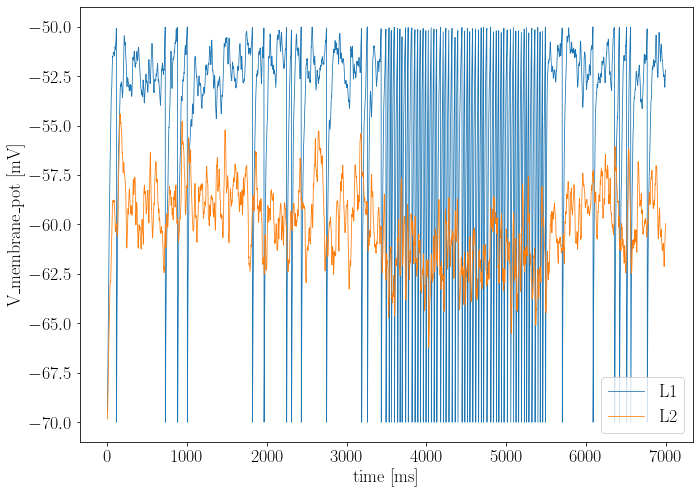

In [86]:
''' some neurons hiddden states '''

variable_to_show = 'V_membrane_pot'       # 'V_membrane_pot', 'I_ex', 'I_in' 
variables_dict = {
    'V_membrane_pot': 0,
    'I_ex':           1,
    'I_in':           2
}


ls = [ 1,2,3 ] if 'SC-BIO' in NETWORK_MODEL else [ 1,2 ]
t = np.loadtxt(f'{sim_dir}_{to_plot_ind}/neuron_states/t.txt')

fig = plt.figure(figsize=(11, 8))

for i_l, l in enumerate(ls):
    data = np.loadtxt(f'{sim_dir}_{to_plot_ind}/neuron_states/L{l}_0.txt').T  
    plt.plot( data[variables_dict[variable_to_show]], label=f'L{l}', color=f'C{i_l}' )

plt.ylabel(f'{variable_to_show} [{"pA" if variable_to_show in ["I_in", "I_ex"] else "mV"}]')
plt.xlabel('time [ms]')
plt.legend()
plt.show()


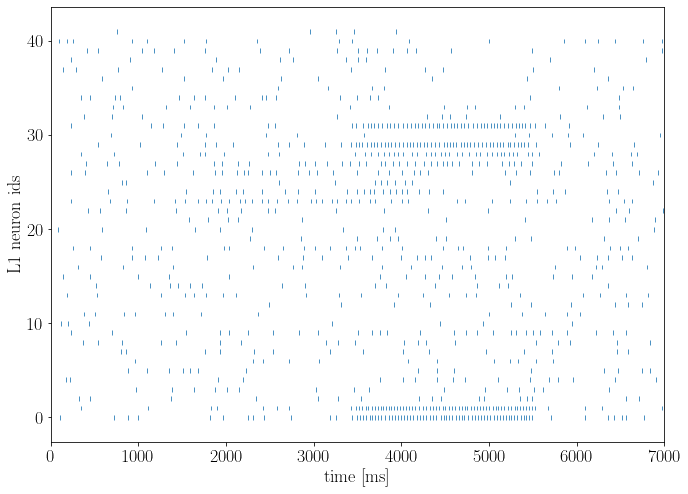

In [87]:
''' some neurons spiking activities '''

pop = 'L1'      # 'L1', 'L2', 'L3' if NETWORK_MODEL = 'SC-BIO-EE' otherwise 'L1', 'L2'

sim = utils.SpikeSim(f'{sim_dir}_{to_plot_ind}', 'sim.yaml', neglect_t=0, neglect_t_end=-1, config_fname='config.yaml')

fig = plt.figure(figsize=(11, 8))
plt.eventplot(sim.data[pop], linelengths=0.5)
plt.xlim(0, ind_dur_ms)
plt.xlabel('time [ms]')
plt.ylabel(f'{pop} neuron ids')
plt.show()

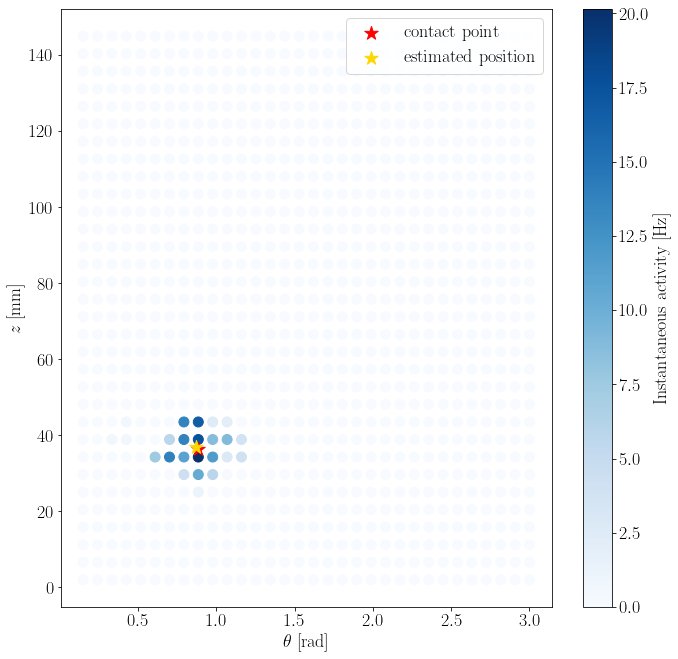

In [ ]:
''' instantaneus activity of the output layer '''

time_to_plot = 4000

out_pop = 'L3' if 'SC-BIO' in NETWORK_MODEL else 'L2'

order_LL = np.loadtxt( f'indentation_example/order_N.txt' ).astype(int)
Zs_LL = np.linspace( 2., 145., 32 )       # mm
Ts_LL = np.linspace( 0.15,3.,  32 )       # rad

T,Z = np.meshgrid(Ts_LL, Zs_LL)
T_shuff = T.flatten()[order_LL]
Z_shuff = Z.flatten()[order_LL]

fig = plt.figure(figsize=(11, 11))
activities = np.zeros((1024, ind_dur_ms))
out_spikes = sim.data[out_pop]
for neur in range(1024):
    for spike_t in out_spikes[neur]:
        activities[neur] += temp_update(spike_t, ind_dur_ms, 0) 
activities = activities*1000

# position of contact point
R_ind, T_ind, Z_ind_ = utils.cartesian_to_cilindric(X_ind[to_plot_ind], Y_ind[to_plot_ind], Z_ind[to_plot_ind])

# instantaneus estimate of the contact position
instant_activities = activities[:,time_to_plot]
instant_activities_thr = np.where(instant_activities>=np.quantile(instant_activities, 0.9), instant_activities, 0.)
prob = instant_activities_thr/np.sum(instant_activities_thr)
Z_inst = np.sum(prob*Z_shuff)
T_inst = np.sum(prob*T_shuff)

plt.scatter(T_shuff, Z_shuff, c=instant_activities, cmap='Blues', s=100)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Instantaneous activity [Hz]')
plt.scatter(T_ind, Z_ind_, c='red', marker='*', s=200, label = 'contact point')
plt.scatter(T_inst, Z_inst, c='gold', marker='*', s=200, label = 'estimated position')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel(r'$z$ [mm]')
plt.legend(loc='upper right')

plt.show()
